In [ ]:
from model import ToyNet, UNet
from diffusion import DiffusionProcess
import torch
from diffusion.utils.sde import SDE
import numpy as np
import logging

from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
from torch.distributions import Normal, Categorical, MixtureSameFamily
import torch

device = 'cuda:0'
import random
from src.PCF_with_empirical_measure import PCF_with_empirical_measure




def init_seed(seed):
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
init_seed(1)

class SDEProcess(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.1, "beta_max": 20},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}}, 
                 **kwargs):
        super(SDEProcess, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size
        self.sde = SDE(self.total_steps, sde_type, sde_info)
        
    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation: 
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t

    
    def backward_one_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        z = torch.randn_like(x_t).to(device)
        f_t, g_t = self.sde.drifts(x_t, t)
        f_t = f_t.to(device)
        x_prev = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
        if clip_denoised and x_t.ndim > 2:
            print('backward_one_step')
            x_prev.clamp_(-1., 1.)

        return x_prev
    
    def backward_k_step(self, x_t, t, step, net, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        for i in range(step):
            z = torch.randn_like(x_t).to(device)
            pred_score = net(x_t, t)
            f_t, g_t = self.sde.drifts(x_t, t)
            f_t = f_t.to(device)
            x_t = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
            t = t - 1
            if clip_denoised and x_t.ndim > 2:
                print('backward_one_step')
                x_t.clamp_(-1., 1.)

        return x_t

    @torch.no_grad()
    def sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)
    
    def forward_sample(self, data):
        trajs = torch.zeros([len(data), self.total_steps+1])
        x = data.to(device)
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t)
            trajs[:, t] = x
        return x, trajs
    
    def backward_sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score) #.detach()
            trajs.append(x_t)
        # print(x_t.shape, torch.hstack(trajs).shape)
        return x_t, torch.hstack(trajs)
    
    def q_step_backward_sample(self, noise, net, step, end_t):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(end_t-step+1, end_t)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score) #.detach()
            trajs.append(x_t)
        # print(x_t.shape, torch.hstack(trajs).shape)
        return x_t, torch.hstack(trajs)
    

    def backward_sample_example(self, forward_process, net, skip_step=1):
        """
        Sample from backward diffusion process
        forward_process: torch.tensor, shape=[num_paths, T]
        """

        forward_end = forward_process[:, -1]
        #flipped_backward_trajs = torch.zeros_like(forward_process)
        #flipped_backward_trajs[:, -1] = forward_end
        backward_trajs = []
        forward_trajs = []
        backward_trajs.append(forward_end.unsqueeze(1))
        forward_trajs.append(forward_end.unsqueeze(1))
        for t in range(self.total_steps, skip_step-1, -skip_step):
            x_t = self.backward_k_step(forward_process[:,t].unsqueeze(1), t, skip_step, net)
            backward_trajs.append(x_t)
            forward_trajs.append(forward_process[:,t-skip_step].unsqueeze(1))
        left_steps = t - skip_step
        while left_steps > 0:
            pred_score = net(forward_process[:,left_steps].unsqueeze(1), left_steps)
            x_t = self.backward_one_step(x_t, left_steps, pred_score)
            backward_trajs.append(x_t)
            forward_trajs.append(forward_process[:,left_steps-1].unsqueeze(1)) 
            left_steps -= 1
        forward_trajs = torch.stack(forward_trajs, dim=1)
        backward_trajs = torch.stack(backward_trajs,dim=1)
        return x_t, forward_trajs, backward_trajs 

            
mix = Categorical(torch.ones(2,))
comp = Normal(torch.tensor([0 - 2., 0 + 2.]), torch.tensor([.5, .5]))
data_dist = MixtureSameFamily(mix, comp)


In [ ]:
score_net = ToyNet(data_dim=1).to(device)
total_steps = 100
num_paths = 32
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

pcf = PCF_with_empirical_measure(16, 10, 1, add_time=True)
pcf = pcf.to(device)

G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-4)
D_opt = torch.optim.Adam(pcf.parameters(), lr=1e-4)

In [ ]:
import torch.nn.functional as F
def loss_function(x0, diffusion_process, score_net, t):
    #f_t is not involved in the score matching loss soe input zeros for the 1st argument.
    #
    _, g_t = diffusion_process.sde.drifts(torch.zeros_like(x0), t)
    
    # Eq 29 in Score based diffusion model (Yang Song 2021 ICLR)
    mean, std = diffusion_process.sde.perturbation_kernel(x0, t)
    z = torch.randn_like(x0)

    x_t = mean + std * z  # x_t is perturbed x_0
    pred_score = score_net(x_t, t)
    target = -z / std   # Since desired derivative of the given kernel is - (x_t - mean) / std^2
    loss = g_t**2 * F.mse_loss(pred_score, target, reduction="sum") / np.prod(x0.size())
    return loss

In [ ]:
num_epochs = 2000

for i in range(num_epochs):

    x_data = data_dist.sample([num_paths])
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
        
    q_step = 15
    t_sample = torch.randint(q_step, total_steps+1, (1,)).item()
    
    # train the PCF network as a discriminator. We want PCF has a great ablitily to distinguish the real data and the generated data. 
    # So we train the PCF to maxmise the distance between the real data and the generated data.
    with torch.no_grad():
        x_gen, traj_back = diffusion.q_step_backward_sample(traj_forward[:,t_sample].unsqueeze(1), score_net,q_step,t_sample)
        traj_forward_flip = torch.fliplr(traj_forward[:,t_sample-q_step:t_sample])

    pcf.train()
    D_loss = -pcf.distance_measure(traj_forward_flip.view([-1, q_step, 1]), traj_back.view([-1, q_step, 1]), Lambda=1.0)

    D_opt.zero_grad()
    D_loss.backward()
    D_opt.step()
   
    # train the score network to minmise the distance between the real data and the generated data
    x_gen1, traj_back1 = diffusion.q_step_backward_sample(traj_forward[:,t_sample].unsqueeze(1), score_net,q_step,t_sample)
    
    t = np.random.randint(1, total_steps + 1)
    score_loss = loss_function(x_data.view(-1 ,1).to(device), diffusion, score_net, t)
    pcf.eval()
    
    G_loss =  pcf.distance_measure(traj_forward_flip.view([-1, q_step, 1]), traj_back1.view([-1, q_step, 1]), Lambda=1.0) + 0.1*score_loss
        
    G_opt.zero_grad()
    G_loss.backward()
    G_opt.step()

    print(i, D_loss.item() , G_loss.item())

In [ ]:
x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 1]).cuda(), score_net)
xxx = np.linspace(0, 1, traj_forward.shape[1])
for line in traj_back:
    plt.plot(xxx, line.cpu(), linewidth=1.0)
    plt.title('backward')

In [ ]:
torch.save(score_net.state_dict(), './score_net_15steps+score.pt')
torch.save(pcf.state_dict(), './pcf_15steps+score.pt')

# Evaluate the model's performance  

Compare the model performance in two situations.
Models: 

Model 1: 2 steps (reconstruction loss+ PCF loss)

Model 2: 1 steps (reconstruction loss+ PCF loss)

Model 3: Train with score matching like other normal methods.

Two situations:
1. Compare the distribution of the forward process and bardward process.
2. Compare the distribution of the X_0 and Y_0. 

Metrics:
marginal distribution score
covariance score

In [1]:
from model import ToyNet, UNet
from diffusion import DiffusionProcess
import torch
from diffusion.utils.sde import SDE
import numpy as np
import logging

from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
from torch.distributions import Normal, Categorical, MixtureSameFamily
import torch

device = 'cuda:0'
import random
from src.PCF_with_empirical_measure import PCF_with_empirical_measure




def init_seed(seed):
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
init_seed(1)

class SDEProcess(DiffusionProcess):
    def __init__(self, sde_type="VP",
                 sde_info={"VP": {"beta_min": 0.1, "beta_max": 20},
                           "subVP": {"beta_min": 0.1, "beta_max": 20},
                           "VE": {"sigma_min": 0.01, "sigma_max": 50}}, 
                 **kwargs):
        super(SDEProcess, self).__init__(**kwargs)
        assert self.discrete is False, "DDPM is only for continuous data"
        self.dt = 1. / self.total_steps # step size
        self.sde = SDE(self.total_steps, sde_type, sde_info)
        
    def forward_one_step(self, x_prev, t):
        """
        Discretized forward SDE process for actual compuatation: 
        x_{t+1} = x_t + f_t(x_t) * dt + G_t * z_t * sqrt(dt)
        """
        f_t, g_t = self.sde.drifts(x_prev, t-1)
        z = torch.randn_like(x_prev)
        x_t = x_prev + f_t * self.dt + g_t * z * np.sqrt(self.dt)
        return x_t

    
    def backward_one_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        z = torch.randn_like(x_t).to(device)
        f_t, g_t = self.sde.drifts(x_t, t)
        f_t = f_t.to(device)
        # x_prev = x_t +
        x_prev = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
        if clip_denoised and x_t.ndim > 2:
            print('backward_one_step')
            x_prev.clamp_(-1., 1.)

        return x_prev
    
    def backward_two_step(self, x_t, t, pred_score, clip_denoised=True):
        """
        Discretized backward SDE process for actual compuatation:
        x_{t-1} = x_t - (f_t(x_t) - (G_t)^2 * pred_score) * dt + G_t * z_t * sqrt(dt)
        """
        for i in range(2):
            z = torch.randn_like(x_t).to(device)
            f_t, g_t = self.sde.drifts(x_t, t)
            f_t = f_t.to(device)
            x_t = x_t - (f_t - g_t**2 * pred_score) * self.dt + g_t * z * np.sqrt(self.dt)
            t = t - 1
            if clip_denoised and x_t.ndim > 2:
                print('backward_one_step')
                x_t.clamp_(-1., 1.)

        return x_t

    @torch.no_grad()
    def sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t, t, pred_score)
            trajs.append(x_t)
        return x_t, torch.hstack(trajs)
    
    def forward_sample(self, data):
        trajs = torch.zeros([len(data), self.total_steps+1])
        x = data.to(device)
        trajs[:, 0] = x
        for t in range(1, self.total_steps+1):
            x = self.forward_one_step(x, t)
            trajs[:, t] = x
        return x, trajs
    
    def backward_sample(self, noise, net):
        """
        Sample from backward diffusion process
        """
        x_t = noise
        trajs = [x_t]

        for t in reversed(range(1, self.total_steps+1)):
            pred_score = net(x_t, t)
            x_t = self.backward_one_step(x_t.detach(), t, pred_score) #
            trajs.append(x_t)
        # print(x_t.shape, torch.hstack(trajs).shape)
        return x_t, torch.hstack(trajs)
    
    def backward_sample_example(self, forward_process, net):
        """
        Sample from backward diffusion process
        forward_process: torch.tensor, shape=[num_paths, T]
        """

        forward_end = forward_process[:, -1]
        flipped_backward_trajs = torch.zeros_like(forward_process)
        flipped_backward_trajs[:, -1] = forward_end
        for t in reversed(range(1, self.total_steps+1,2)):
            pred_score = net(forward_process[:,t].unsqueeze(1), t)
            x_t = self.backward_two_step(forward_process[:,t].unsqueeze(1), t, pred_score)
            flipped_backward_trajs[:,t-1] = x_t.squeeze()
        return x_t, flipped_backward_trajs 

    
mix = Categorical(torch.ones(2,))
comp = Normal(torch.tensor([0 - 2., 0 + 2.]), torch.tensor([.5, .5]))
data_dist = MixtureSameFamily(mix, comp)


In [2]:
score_net = ToyNet(data_dim=1).to(device)
total_steps = 100
num_paths = 32
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")

pcf = PCF_with_empirical_measure(16, 10, 1, add_time=True)
pcf = pcf.to(device)

In [3]:
import torch
from torch.utils.data import Dataset
import numpy as np
from diffusion import DiffusionProcess
from torch.distributions import Normal, Categorical, MixtureSameFamily

class Toy_Dataset(Dataset):
    def __init__(self, phase='test'):
        super(Toy_Dataset, self).__init__()
        if phase == 'test':
            self.num_paths = 10000
        elif phase == 'train':
            self.num_paths = 30000
        self.data = self.create_dataset()
    
    def create_dataset(self):
        mix = Categorical(torch.ones(2,))
        comp = Normal(torch.tensor([0 - 2., 0 + 2.]), torch.tensor([.5, .5]))
        data_dist = MixtureSameFamily(mix, comp)
        total_steps = 100
        num_paths = self.num_paths
        diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP")
        x_data = data_dist.sample([num_paths])
        x_noise, traj_forward = diffusion.forward_sample(x_data)
        traj_forward = traj_forward.to('cpu') # num_paths, total_steps
        return traj_forward
    
    def __len__(self):
        return self.num_paths

    def __iter__(self):
        return self

    def __getitem__(self, index):
        
        return self.data[index]

In [4]:
train_batch_size = 32
test_batch_size = 32
num_worker = 8

train_data_loader = torch.utils.data.DataLoader(
            dataset=Toy_Dataset(phase='train'),
            batch_size = train_batch_size,
            shuffle=True,
            num_workers= num_worker,
            drop_last=True,
            worker_init_fn=init_seed)


test_data_loader = torch.utils.data.DataLoader(
            dataset=Toy_Dataset(phase='test'),
            batch_size = test_batch_size,
            shuffle=False,
            num_workers= num_worker,
            drop_last=False,
            worker_init_fn=init_seed)



In [5]:
diffusion_score_model = ToyNet(data_dim=1).to(device)
diffusion_score_model.load_state_dict(torch.load('./score_net_2steps_less_sup.pt'))
diffusion_score_model.eval()

diffusion_score_model2 = ToyNet(data_dim=1).to(device)
diffusion_score_model2.load_state_dict(torch.load('./score_net_15steps+score.pt'))
diffusion_score_model2.eval()

diffusion_score_model3 = ToyNet(data_dim=1).to(device)
diffusion_score_model3.load_state_dict(torch.load('./score_net_diffusion_loss.pt'))
diffusion_score_model3.eval()

/tmp/ipykernel_3915142/3189687834.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diffusion_score_model.load_state_dict(torch.load('./score_net_2steps_less_sup.pt'))
/tm

ToyNet(
  (t_module): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (x_module): ResNet_FC(
    (map): Linear(in_features=1, out_features=256, bias=True)
    (res_blocks): ModuleList(
      (0-2): 3 x Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): SiLU()
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): SiLU()
        (4): Linear(in_features=256, out_features=256, bias=True)
        (5): SiLU()
      )
    )
  )
  (out_module): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [6]:
from src.utils1 import loader_to_tensor
from src.evaluations.test_metrics import  HistoLoss
from src.evaluations.test_metrics import  CovLoss

def to_numpy(x):
    """
    Casts torch.Tensor to a numpy ndarray.

    The function detaches the tensor from its gradients, then puts it onto the cpu and at last casts it to numpy.
    """
    return x.detach().cpu().numpy()

# Sig_mmd1 = 0
# Sig_mmd2 = 0 
hist_losses1 = []
hist_losses2 = []
hist_losses3 = []
hist_losses4 = []
hist_losses5 = []
hist_losses6 = []

cov_losses1 = []
cov_losses2 = []
cov_losses3 = []
cov_losses4 = []
cov_losses5 = []
cov_losses6 = []
diffusion = SDEProcess(discrete=False, total_steps=100, sde_type="VP")

for forward_bacth in tqdm(test_data_loader, dynamic_ncols=True):
    x_real_test = forward_bacth.cuda()
    forward_end_point = x_real_test[:,-1]
    revsered_traj_init = forward_end_point.unsqueeze(1).cuda()
    x_gen, traj_back = diffusion.sample(revsered_traj_init, diffusion_score_model)
    x_gen2, traj_back2 = diffusion.sample(revsered_traj_init, diffusion_score_model2)
    x_gen2, traj_back3 = diffusion.sample(revsered_traj_init, diffusion_score_model3)
    # test_metrics_test = get_standard_test_metrics(x_real_test.unsqueeze(2))
    # Sig_mmd1 += test_metrics_test[0].compute(traj_back.unsqueeze(2))
    # Sig_mmd2 += test_metrics_test[0].compute(traj_back2.unsqueeze(2))
    hist_losses1.append(to_numpy(
        HistoLoss(x_real_test.unsqueeze(2), n_bins=50, name='marginal_distribution')(torch.fliplr(traj_back).unsqueeze(2))))
    cov_losses1.append(to_numpy(CovLoss(x_real_test.unsqueeze(2), name='covariance')(torch.fliplr(traj_back).unsqueeze(2))))

    hist_losses2.append(to_numpy(
        HistoLoss(x_real_test.unsqueeze(2), n_bins=50, name='marginal_distribution')(torch.fliplr(traj_back2).unsqueeze(2))))
    cov_losses2.append(to_numpy(CovLoss(x_real_test.unsqueeze(2), name='covariance')(torch.fliplr(traj_back2).unsqueeze(2))))
    
    hist_losses3.append(to_numpy(
        HistoLoss(x_real_test[:,0][:,None,None], n_bins=50, name='marginal_distribution')(traj_back[:,-1][:,None,None])))
    cov_losses3.append(to_numpy(CovLoss(x_real_test[:,0][:,None,None], name='covariance')(traj_back[:,-1][:,None,None])))

    hist_losses4.append(to_numpy(
        HistoLoss(x_real_test[:,0][:,None,None], n_bins=50, name='marginal_distribution')(traj_back2[:,-1][:,None,None])))
    cov_losses4.append(to_numpy(CovLoss(x_real_test[:,0][:,None,None], name='covariance')(traj_back2[:,-1][:,None,None])))

    hist_losses5.append(to_numpy(
        HistoLoss(x_real_test.unsqueeze(2), n_bins=50, name='marginal_distribution')(torch.fliplr(traj_back3).unsqueeze(2))))
    cov_losses5.append(to_numpy(CovLoss(x_real_test.unsqueeze(2), name='covariance')(torch.fliplr(traj_back3).unsqueeze(2))))

    hist_losses6.append(to_numpy(
        HistoLoss(x_real_test[:,0][:,None,None], n_bins=50, name='marginal_distribution')(traj_back3[:,-1][:,None,None])))
    cov_losses6.append(to_numpy(CovLoss(x_real_test[:,0][:,None,None], name='covariance')(traj_back3[:,-1][:,None,None])))

# print(Sig_mmd1.item())
# print(Sig_mmd2.item())
hist_mean1, hist_std1 = np.array(hist_losses1).mean(), np.array(hist_losses1).std()
hist_mean2, hist_std2 = np.array(hist_losses2).mean(), np.array(hist_losses2).std()
hist_mean3, hist_std3 = np.array(hist_losses3).mean(), np.array(hist_losses3).std()
hist_mean4, hist_std4 = np.array(hist_losses4).mean(), np.array(hist_losses4).std()
hist_mean5, hist_std5 = np.array(hist_losses5).mean(), np.array(hist_losses5).std()
hist_mean6, hist_std6 = np.array(hist_losses6).mean(), np.array(hist_losses6).std()


cov_mean1, cov_std1 = np.array(cov_losses1).mean(), np.array(cov_losses1).std()
cov_mean2, cov_std2 = np.array(cov_losses2).mean(), np.array(cov_losses2).std()
cov_mean3, cov_std3 = np.array(cov_losses3).mean(), np.array(cov_losses3).std()
cov_mean4, cov_std4 = np.array(cov_losses4).mean(), np.array(cov_losses4).std()
cov_mean5, cov_std5 = np.array(cov_losses5).mean(), np.array(cov_losses5).std()
cov_mean6, cov_std6 = np.array(cov_losses6).mean(), np.array(cov_losses6).std()

print('marginal_distribution loss of the whole process with 2 steps (reconstruction loss+PCF loss) with mean:', hist_mean1, 'std:', hist_std1)
print('marginal_distribution loss of the whole process with score matching loss+ q-step PCF loss with mean:', hist_mean2, 'std:', hist_std2)
print('marginal_distribution loss of the whole process with diffusion loss with mean:', hist_mean5, 'std:', hist_std5)
print('')

print('marginal_distribution loss with 2 steps (reconstruction loss+PCF loss) at the last time point with mean:', hist_mean3, 'std:', hist_std3)
print('marginal_distribution loss with score matching loss+ q-step PCF loss at the last time point with mean:', hist_mean4, 'std:', hist_std4)
print('marginal_distribution loss with diffusion loss at the last time point with mean:', hist_mean6, 'std:', hist_std6)
print('')

print('variance loss of the whole process with 2 steps (reconstruction loss+PCF loss) with mean:', cov_mean1, 'std:', cov_std1)
print('variance loss of the whole process with score matching loss+ q-step PCF loss with mean:', cov_mean2, 'std:', cov_std2)
print('variance loss of the whole process with diffusion loss with mean:', cov_mean5, 'std:', cov_std5)
print('')

print('variance loss at the last time point with 2 steps (reconstruction loss+PCF loss) with mean:', cov_mean3, 'std:', cov_std3)
print('variance loss at the last time point with score matching loss+ q-step PCF loss with mean :', cov_mean4, 'std:', cov_std4)
print('variance loss at the last time point with diffusion loss with mean:', cov_mean6, 'std:', cov_std6)



100%|██████████| 313/313 [02:26<00:00,  2.14it/s]

marginal_distribution loss of the whole process with 2 steps (reconstruction loss+PCF loss) with mean: 0.24289155 std: 0.015236246
marginal_distribution loss of the whole process with score matching loss+ q-step PCF loss with mean: 0.24393266 std: 0.015390043
marginal_distribution loss of the whole process with diffusion loss with mean: 0.24770552 std: 0.015866142

marginal_distribution loss with 2 steps (reconstruction loss+PCF loss) at the last time point with mean: 0.17889237 std: 0.026582615
marginal_distribution loss with score matching loss+ q-step PCF loss at the last time point with mean: 0.18173991 std: 0.028905189
marginal_distribution loss with diffusion loss at the last time point with mean: 0.20270902 std: 0.029722854

variance loss of the whole process with 2 steps (reconstruction loss+PCF loss) with mean: 0.35004604 std: 0.08799991
variance loss of the whole process with score matching loss+ q-step PCF loss with mean: 0.3455054 std: 0.08445728
variance loss of the whole 

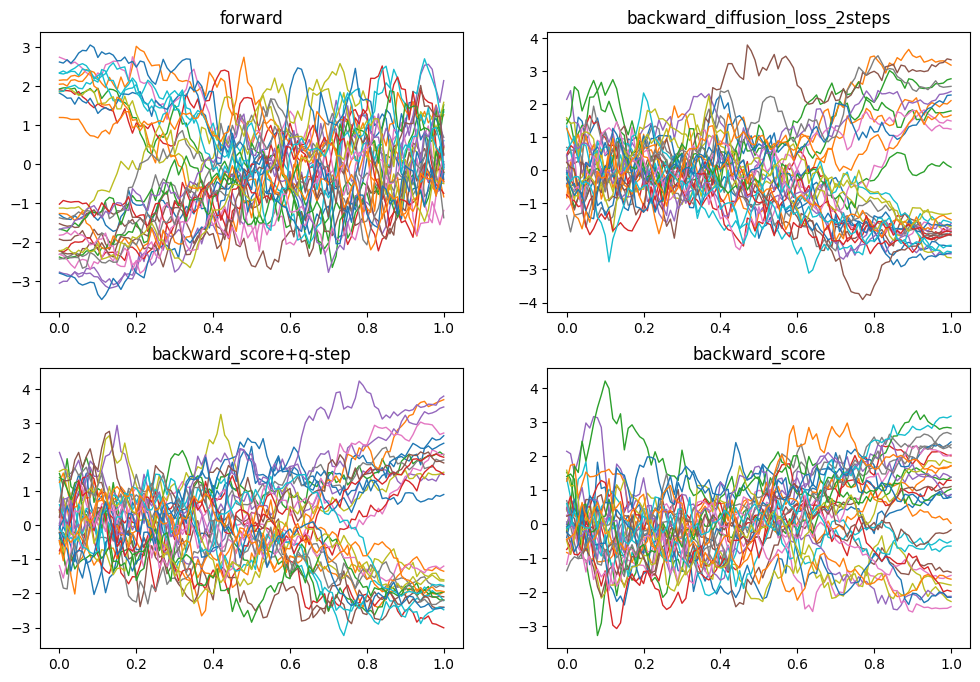

In [10]:
for forward_batch in test_data_loader:
    x_real_test = forward_batch.cuda()
    forward_end_point = x_real_test[:,-1]
    revsered_traj_init = forward_end_point.unsqueeze(1).cuda()
    x_gen, traj_back = diffusion.sample(revsered_traj_init, diffusion_score_model)
    x_gen2, traj_back2 = diffusion.sample(revsered_traj_init, diffusion_score_model2)
    x_gen3, traj_back3 = diffusion.sample(revsered_traj_init, diffusion_score_model3)   
    xxx = np.linspace(0, 1, x_real_test.shape[1])
    fig, axs = plt.subplots(2, 2, figsize=(12, 8)) 
    # plt.subplots_adjust(wspace=0.5)

    # plt.subplot(2, 2, 1)
    for line in x_real_test:
        axs[0, 0].plot(xxx, line.cpu(), linewidth=1.0)
        axs[0, 0].set_title('forward')


    # plt.subplot(2, 2, 2)
    for line in traj_back:
        axs[0, 1].plot(xxx, line.cpu(), linewidth=1.0)
        axs[0, 1].set_title('backward_diffusion_loss_2steps')


    # plt.subplot(2, 2, 3)
    for line in traj_back2:
        axs[1, 0].plot(xxx, line.cpu(), linewidth=1.0)
        axs[1, 0].set_title('backward_score+q-step')

    for line in traj_back3:
        axs[1, 1].plot(xxx, line.cpu(), linewidth=1.0)
        axs[1, 1].set_title('backward_score')
    break
